In [1]:
%%capture
%pip install matplotlib

In [2]:
import numpy as np
from  sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt
import time as tm

In [3]:
def my_map( X ):
################################
#  Non Editable Region Ending  #
################################	
	# Use this method to create features.
	# It is likely that my_fit will internally call my_map to create features for train points
	n_samples, n_features = X.shape
	feat = np.empty((n_samples, 2 * n_features - 1))
	X = 1 - 2 * X
	feat[:, :31] = X[:, :31]
	feat[:, 31] = X[:, 31]
	cumulative_products = np.cumprod(X[:, ::-1], axis=1)[:, ::-1]
	feat[:, 32:] = cumulative_products[:, 1:]
	
	return feat

In [4]:
def my_fit( X_train, y0_train, y1_train, inp):
################################
#  Non Editable Region Ending  #
################################

	# Use this method to train your models using training CRPs
	# X_train has 32 columns containing the challenge bits
	# y0_train contains the values for Response0
	# y1_train contains the values for Response1
	
	# THE RETURNED MODELS SHOULD BE TWO VECTORS AND TWO BIAS TERMS
	# If you do not wish to use a bias term, set it to 0
	model = LinearSVC(C=1000, tol=inp, penalty='l2', max_iter=1000, loss='squared_hinge', dual=False)
	# model2 = LinearSVC(C=inp, tol=1e-5, penalty='l2', max_iter=1000, loss='squared_hinge', dual=False)
	# model = LinearSVC(C=inp, tol=1e-5, penalty='l2', max_iter=2000, loss='hinge', dual=True)
	# model = LogisticRegression(C=100, tol=inp, penalty='l2', max_iter=1000, solver='liblinear')
	feat = my_map(X_train)
	model.fit(feat, y0_train)
	w0 = model.coef_
	b0 = model.intercept_

	model.fit(feat, y1_train)
	w1 = model.coef_
	b1 = model.intercept_
	return w0, b0, w1, b1

In [5]:
Z_trn = np.loadtxt( "public_trn.txt" )
Z_tst = np.loadtxt( "public_tst.txt" )

n_trials = 5

test_loss_0 = []
test_loss_1 = []
train_time = []
c_value = []

In [6]:
inp = 1e-7
while inp <= 1e2:
    d_size = 0
    t_train = 0
    t_map = 0
    acc0 = 0
    acc1 = 0
    for t in range(n_trials):
        tic = tm.perf_counter()
        w0, b0, w1, b1 = my_fit(Z_trn[:, :-2], Z_trn[:, -2], Z_trn[:, -1], inp)
        toc = tm.perf_counter()

        t_train += toc - tic
        w0 = w0.reshape(-1)
        w1 = w1.reshape(-1)

        d_size += max(w0.shape[0], w1.shape[0])

        tic = tm.perf_counter()
        feat = my_map(Z_tst[:, :-2])
        toc = tm.perf_counter()
        t_map += toc - tic

        scores0 = feat.dot(w0) + b0
        scores1 = feat.dot(w1) + b1

        pred0 = np.zeros_like(scores0)
        pred0[scores0 > 0] = 1
        pred1 = np.zeros_like(scores1)
        pred1[scores1 > 0] = 1

        acc0 += np.average(Z_tst[:, -2] == pred0)
        acc1 += np.average(Z_tst[:, -1] == pred1)

    d_size /= n_trials
    t_train /= n_trials
    t_map /= n_trials
    acc0 /= n_trials
    acc1 /= n_trials
    print( f"{d_size},{t_train},{t_map},{1 - acc0},{1 - acc1}" )
    test_loss_0.append(1 - acc0)
    test_loss_1.append(1 - acc1)
    train_time.append(t_train)
    c_value.append(inp)
    inp *= 10

63.0,1.1536203816067427,0.009030437446199358,0.01990000000000003,0.0006000000000000449
63.0,0.8976606987882405,0.0070658277720212935,0.01990000000000003,0.0006000000000000449
63.0,0.6727079444099218,0.00630062238778919,0.01990000000000003,0.0004999999999999449
63.0,0.6147308739833534,0.0081061992328614,0.01990000000000003,0.0004999999999999449
63.0,0.5407675452297553,0.005712981591932476,0.019999999999999907,0.0010000000000000009
63.0,0.47486253357492386,0.006218940578401088,0.01990000000000003,0.0039000000000000146
63.0,0.3362134711816907,0.005801189015619457,0.01959999999999995,0.007300000000000084
63.0,0.21740930317901075,0.006954522989690304,0.025800000000000045,0.015800000000000147
63.0,0.16866759941913187,0.006561687798239291,0.5001,0.5094000000000001
63.0,0.1459143826039508,0.006377023202367127,0.5001,0.5094000000000001


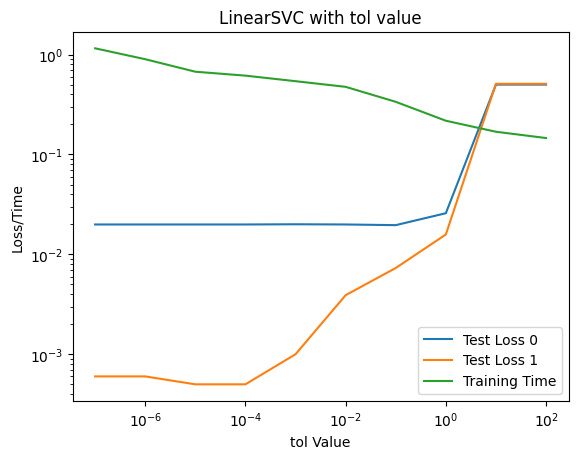

In [7]:
plt.plot(c_value, test_loss_0, label='Test Loss 0')
plt.plot(c_value, test_loss_1, label='Test Loss 1')
plt.plot(c_value, train_time, label='Training Time')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('tol Value')
plt.ylabel('Loss/Time')
plt.legend()
plt.title('LinearSVC with tol value')
plt.savefig('LinearSVC with tol value.png')
plt.show()